# Create a 30-spill sample .csv from 10,000 spill file
- Subsample 30 most (a) eastern locations, (b) biggest spills, (c) spills closest to Tun Point and (d) spills closest to BP
- Plot spill locations on map

In [117]:
import cartopy.crs
from cartopy import feature
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy
import xarray
import pandas
import pathlib
import yaml
import math
from haversine import haversine

In [118]:
# map information
mesh_mask = xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn2DMeshMaskV17-02")
water_mask = mesh_mask.tmaskutil.isel(time=0)
fields = xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV19-05")
georef = xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSnBathymetryV17-02")

## Graphic specifications

In [119]:
# create dictionary for labeling Lagrangian files
oil_types = {
    "Lagrangian_bunker.dat": "Bunker-C",
    "Lagrangian_akns.dat": "ANS",
    "Lagrangian_diesel.dat": "Diesel",
    "Lagrangian_dilbit.dat": "Dilbit",
    "Lagrangian_other.dat": "Other",
    "Lagrangian_jet.dat": "Jet Fuel",
    "Lagrangian_gas.dat": "Gasoline"
}
mpl.rc('font', size=11)
# some of the following may be repetetive but can also be set relative to the font value above 
#    (eg "xx-small, x-small,small, medium, large, x-large, xx-large, larger, or smaller"; see link above for details)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('legend', fontsize=12)
mpl.rc('axes', titlesize=16)
mpl.rc('axes', labelsize=12)
mpl.rc('figure', titlesize=16)
mpl.rc('text', usetex=False)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

# load spills file

In [120]:
# spill csv file location
file_dir = pathlib.Path('/ocean/rmueller/MIDOSS/spill_files_mctest/')
spill_locations = file_dir / 'SalishSea_oil_spills_1.csv'
# load spill locations
spill_locs_all = pandas.read_csv(spill_locations)

# Separate spills  > 3L

In [121]:
spill_locs = spill_locs_all.loc[
    spill_locs_all.spill_volume > 3
]
spill_locs.shape[0]

9828

# Select sorting criteria and define sub-sample size

In [135]:
nrows = 30
sortby = "bp"
spill_locs_30 = {}

lat = {}
lon = {}
# turn point
lat['tp'] = 48.68813
lon['tp'] = -123.23622
# BP
lat['bp'] = 48.86111
lon['bp'] = -122.758

### Sub-sample 30 spill locations based on Easternmost locations

In [123]:
# sort the spills by longitude
spill_locs = spill_locs.sort_values(
    by="spill_lon",
    ascending=False).reset_index(drop=True)
# extract the first nrows
spill_locs_30["easternmost"] = spill_locs.iloc[:nrows]

### Sub-sample 30 spill locations based on biggest spills

In [124]:
# sort the spills by volume
spill_locs = spill_locs.sort_values(
    by="spill_volume",
    ascending=False).reset_index(drop=True)
# extract the first nrows
spill_locs_30["largest"] = spill_locs.iloc[:nrows]

### Sub-sample 30 nearest spills to Turn Point

In [125]:
tp = (lat['tp'],lon['tp'])
spill_locs['distance_tp'] = numpy.zeros(spill_locs['spill_lat'].shape[0])
for idx,spill_lats in enumerate(spill_locs['spill_lat']):
    spill_site = (spill_locs['spill_lat'][idx], spill_locs['spill_lon'][idx])
    spill_locs['distance_tp'][idx] = haversine(
        tp, 
        spill_site
    )
# sort the spills by distance to TP
spill_locs = spill_locs.sort_values(
    by="distance_tp",
    ascending=True).reset_index(drop=True)
# extract the 30 closest spills to TP
spill_locs_30["Turn Point"] = spill_locs.iloc[:nrows]
if sortby == 'tp':
    spill_locs.to_csv(file_dir / f'SalishSea_oil_spills_1_gt3_TP{nrows}.csv')

/tmp/ipykernel_19522/3223139928.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spill_locs['distance_tp'][idx] = haversine(


In [137]:
bp = (lat['bp'],lon['bp'])
spill_locs['distance_bp'] = numpy.zeros(spill_locs['spill_lat'].shape[0])
for idx,spill_lats in enumerate(spill_locs['spill_lat']):
    spill_site = (spill_locs['spill_lat'][idx], spill_locs['spill_lon'][idx])
    spill_locs['distance_bp'][idx] = haversine(
        bp, 
        spill_site
    )
# sort the spills by distance to BP marine terminal
spill_locs = spill_locs.sort_values(
    by="distance_bp",
    ascending=True).reset_index(drop=True)
# extract the 30 closest spills to TP
spill_locs_30["BP terminal"] = spill_locs.iloc[:nrows]
# Save values to file
if sortby == 'bp':
    spill_locs.to_csv(file_dir / f'SalishSea_oil_spills_1_gt3_BP{nrows}.csv')

/tmp/ipykernel_19522/3617158468.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spill_locs['distance_bp'][idx] = haversine(


### Plot locations

In [127]:
# define axis limits
axlim = numpy.zeros(4)
axlim[0] = spill_locs.spill_lon.min()
axlim[1] = spill_locs.spill_lon.max()
axlim[2] = spill_locs.spill_lat.min()
axlim[3] = spill_locs.spill_lat.max()

In [128]:
# create list of key names
grouping = [*spill_locs_30]
grouping

['easternmost', 'largest', 'Turn Point', 'BP terminal']

[<GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:>]
easternmost
largest
Turn Point
BP terminal


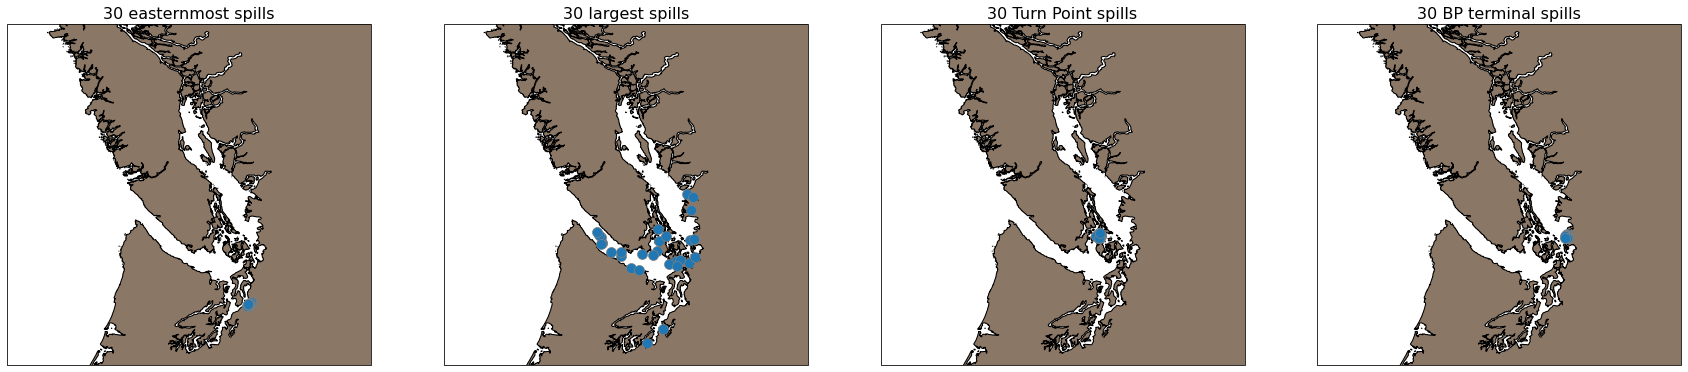

In [129]:
import matplotlib.gridspec as gridspec

rotated_crs = cartopy.crs.RotatedPole(
    pole_longitude=120.0, 
    pole_latitude=63.75
)
plain_crs = cartopy.crs.PlateCarree()

%matplotlib inline    

fig,axs = plt.subplots(
    1, len(grouping), figsize=(30, 15), 
    subplot_kw={"projection": rotated_crs, "facecolor": "white"}
)
print(axs)
for idx,group_id in enumerate(grouping):
    print(group_id)
    terminal_loc = 0
    axs[idx].add_feature(feature.GSHHSFeature(
        'full', 
        edgecolor='k', 
        facecolor='#8b7765'
    ), zorder=1)
    scatter_bunker = axs[idx].scatter(
        spill_locs_30[group_id].spill_lon, 
        spill_locs_30[group_id].spill_lat, 
        s = 100, #ms * spill_volume_fraction,
        #label = spill_volume_fraction.values.tolist(),
        #color='yellow',
        #alpha = 0.5,
        edgecolors='grey',
        linewidth=0.7,
        transform=plain_crs,
        zorder=2)
    axs[idx].set_extent(axlim, crs=plain_crs)
    axs[idx].set_title(f'30 {group_id} spills')
plt.show()

## Plot histograms of spill volume and oil types for TP and BP

In [130]:
# identify maximum spill volume in these cases to scale x-limit
max_volume = 0
for group_id in ["Turn Point", "BP terminal"]:
    max_volume = max(max_volume,max(spill_locs_30[group_id]["spill_volume"]))
    print(max_volume)
max_volume = math.ceil(max_volume/1e6)*1e6
print(max_volume)

5830000.0
11349000.0
12000000.0


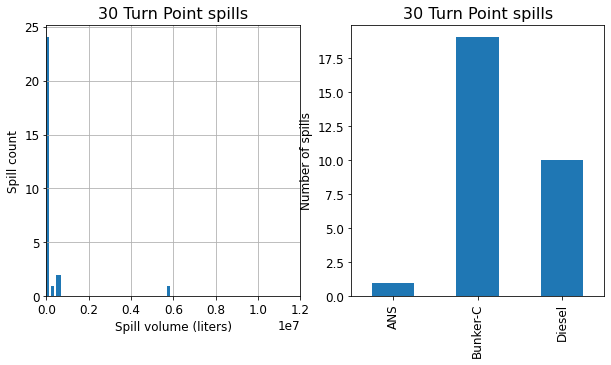

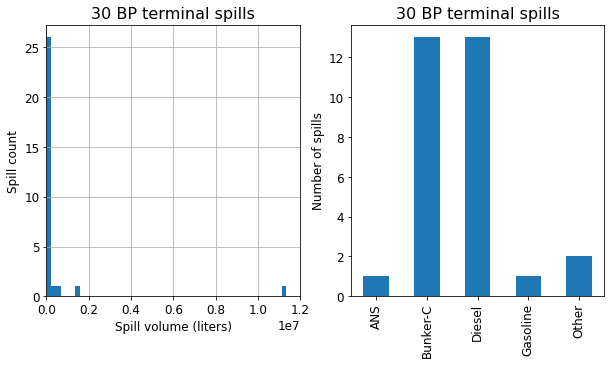

In [131]:
# plot histograms for the two regions
for group_id in ["Turn Point", "BP terminal"]:
    fig,axs = plt.subplots(
        1, 2, figsize=(10, 5), 
    )
    
    # plot histogram of spill volume
    spill_locs_30[group_id]["spill_volume"].hist(ax=axs[0],bins=50)
    axs[0].set_ylabel('Spill count')
    axs[0].set_xlabel('Spill volume (liters)')
    axs[0].set_xlim([0, max_volume])
    axs[0].set_title(f'30 {group_id} spills')
    
    # plot histogram of oil types
    plot_info = spill_locs_30[group_id].groupby("Lagrangian_template").count()
    # create ordered list of fuel types for x-labels
    x_labels = [] 
    for key in [*plot_info.index]:        
        x_labels.append(oil_types[key]) 
    # plot number of spills by oil type
    plot_info.spill_date_hour.plot(ax=axs[1],kind='bar')
    axs[1].set_xticklabels(x_labels, rotation=90)
    axs[1].set_xlabel('')
    axs[1].set_ylabel('Number of spills')
    axs[1].set_title(f'30 {group_id} spills')

In [132]:
spill_locs_30["Turn Point"]

,spill_date_hour,run_days,spill_lon,spill_lat,geotiff_x_index,geotiff_y_index,vessel_type,vessel_len,vessel_mmsi,vessel_origin,vessel_dest,fuel_capacity,cargo_capacity,spill_volume,fuel_cargo,Lagrangian_template,distance_tp
0,2018-12-27 10:00,7,-123.238002,48.690547,256,542,cargo,294,211331640,NaN,NaN,2.670962e+06,0.0,2.670962e+04,fuel,Lagrangian_bunker.dat,0.298852
1,2018-08-14 15:00,7,-123.243828,48.686687,257,542,cargo,292,636014630,NaN,NaN,4.096686e+06,0.0,4.096686e+04,fuel,Lagrangian_bunker.dat,0.581048
2,2018-07-19 06:00,7,-123.237630,48.682059,257,542,cargo,199,538006751,NaN,NaN,2.113502e+06,0.0,2.113502e+04,fuel,Lagrangian_bunker.dat,0.682960
3,2018-03-30 05:00,7,-123.229324,48.693726,256,542,cargo,228,311057300,NaN,NaN,1.357950e+06,0.0,1.357950e+04,fuel,Lagrangian_bunker.dat,0.802078
4,2018-10-25 05:00,7,-123.243078,48.693859,256,542,cargo,300,352725000,NaN,NaN,4.702470e+06,0.0,5.172717e+05,fuel,Lagrangian_bunker.dat,0.811913
5,2018-12-28 20:00,7,-123.248904,48.690000,257,541,other,29,316012721,NaN,NaN,3.585255e+04,0.0,1.039724e+04,fuel,Lagrangian_diesel.dat,0.953995
6,2018-03-21 05:00,7,-123.231552,48.696358,256,542,tanker,183,565429000,Pacific,Canada,1.925911e+06,53000000.0,1.925911e+04,fuel,Lagrangian_bunker.dat,0.976935
7,2018-11-24 03:00,7,-123.225235,48.696949,256,543,other,11,368035840,NaN,NaN,2.311546e+02,0.0,1.155773e+01,fuel,Lagrangian_diesel.dat,1.269548
8,2018-08-29 09:00,7,-123.233790,48.674839,258,542,other,20,367434940,NaN,NaN,3.116683e+03,0.0,1.589508e+03,fuel,Lagrangian_diesel.dat,1.488620
9,2018-08-24 18:00,7,-123.254982,48.675701,257,541,ferry,0,316034095,NaN,NaN,2.598955e+04,0.0,6.497387e+03,fuel,Lagrangian_diesel.dat,1.951225


In [133]:
spill_locs_30["BP terminal"]

,spill_date_hour,run_days,spill_lon,spill_lat,geotiff_x_index,geotiff_y_index,vessel_type,vessel_len,vessel_mmsi,vessel_origin,vessel_dest,fuel_capacity,cargo_capacity,spill_volume,fuel_cargo,Lagrangian_template,distance_tp,distance_bp
0,2018-07-20 16:00,7,-122.759438,48.863299,245,574,atb,178,368006870,NaN,NaN,4.748341e+05,2.128268e+07,1.489787e+06,cargo,Lagrangian_bunker.dat,40.000472,0.265157
1,2018-04-23 05:00,7,-122.758207,48.867190,245,574,barge,31,367328780,BP Cherry Point Refinery,US,1.260590e+05,9.100000e+06,1.890885e+04,fuel,Lagrangian_diesel.dat,40.290134,0.676240
2,2018-07-22 08:00,7,-122.759051,48.854838,245,574,atb,34,367646810,NaN,NaN,2.183521e+05,2.128268e+07,2.183521e+03,fuel,Lagrangian_bunker.dat,39.578517,0.701635
3,2018-03-29 13:00,7,-122.764763,48.856204,245,574,barge,40,366866930,Phillips 66 Ferndale Refinery,BP Cherry Point Refinery,3.568347e+05,5.200000e+06,5.200000e+04,cargo,Lagrangian_bunker.dat,39.280775,0.736486
4,2018-10-20 23:00,7,-122.753611,48.867138,245,574,barge,30,366919770,BP Cherry Point Refinery,US,2.630589e+05,2.610000e+07,2.630589e+03,fuel,Lagrangian_diesel.dat,40.580388,0.743189
5,2018-10-13 22:00,7,-122.766500,48.855573,245,574,barge,40,366866930,BP Cherry Point Refinery,US,2.450522e+05,2.030000e+07,2.695574e+04,fuel,Lagrangian_diesel.dat,39.135639,0.875066
6,2018-10-20 06:00,7,-122.755854,48.869765,245,574,barge,51,366767150,BP Cherry Point Refinery,BP Cherry Point Refinery,3.542246e+05,2.600000e+06,4.604920e+04,fuel,Lagrangian_diesel.dat,40.581026,0.975104
7,2018-09-26 10:00,7,-122.755854,48.869765,245,574,atb,34,367740790,NaN,NaN,3.019230e+05,1.953281e+07,1.953281e+05,cargo,Lagrangian_gas.dat,40.581026,0.975104
8,2018-06-03 12:00,7,-122.772102,48.862141,245,573,barge,31,367328780,Phillips 66 Ferndale Refinery,BP Cherry Point Refinery,2.492540e+05,1.300000e+07,2.492540e+03,fuel,Lagrangian_diesel.dat,39.128973,1.037976
9,2018-06-09 23:00,7,-122.765999,48.852315,245,574,tanker,183,367353110,US,BP Cherry Point Refinery,1.333530e+06,5.300000e+07,6.667650e+04,fuel,Lagrangian_bunker.dat,38.998032,1.139651


In [134]:
spill_locs_30["largest"]

,spill_date_hour,run_days,spill_lon,spill_lat,geotiff_x_index,geotiff_y_index,vessel_type,vessel_len,vessel_mmsi,vessel_origin,vessel_dest,fuel_capacity,cargo_capacity,spill_volume,fuel_cargo,Lagrangian_template
0,2018-12-23 03:00,7,-124.073255,48.283605,284,486,tanker,273,338371000,Pacific,Phillips 66 Ferndale Refinery,2.675034e+06,1.854470e+08,1.390852e+08,cargo,Lagrangian_akns.dat
1,2018-07-10 18:00,7,-123.849337,48.219827,288,501,tanker,274,249889000,Pacific,BP Cherry Point Refinery,2.906959e+06,1.854470e+08,9.457797e+07,cargo,Lagrangian_gas.dat
2,2018-12-18 01:00,7,-123.656761,48.220768,288,514,tanker,228,538001893,Pacific,Canada,1.370694e+06,1.262110e+08,6.941605e+07,cargo,Lagrangian_akns.dat
3,2018-07-26 10:00,7,-122.775050,48.780150,251,573,tanker,287,303294000,BP Cherry Point Refinery,Shell Puget Sound Refinery,3.829497e+06,1.854470e+08,5.748857e+07,cargo,Lagrangian_diesel.dat
4,2018-04-07 04:00,7,-123.398371,48.134981,294,531,tanker,274,538006650,NaN,NaN,2.642758e+06,1.854470e+08,5.377963e+07,cargo,Lagrangian_akns.dat
5,2018-08-28 07:00,7,-123.367490,48.356065,279,533,tanker,184,538006302,Canada,Canada,9.445234e+05,5.300000e+07,5.035000e+07,cargo,Lagrangian_akns.dat
6,2018-06-25 15:00,7,-123.169978,48.475520,271,547,tanker,213,636016731,Pacific,Canada,1.617946e+06,1.262110e+08,4.669807e+07,cargo,Lagrangian_diesel.dat
7,2018-10-03 06:00,7,-122.780495,48.459058,272,573,tanker,273,369272000,Shell Puget Sound Refinery,Pacific,1.085188e+06,1.854470e+08,4.265281e+07,cargo,Lagrangian_gas.dat
8,2018-12-06 03:00,7,-124.066958,48.284232,284,486,tanker,176,219124000,NaN,NaN,4.976642e+05,5.300000e+07,4.187000e+07,cargo,Lagrangian_gas.dat
9,2018-12-08 19:00,7,-124.144414,48.338736,280,481,tanker,183,538003758,NaN,NaN,1.330027e+06,5.300000e+07,3.657000e+07,cargo,Lagrangian_akns.dat
